In [1]:
# Modified from https://rumn.medium.com/custom-pytorch-image-classifier-from-scratch-d7b3c50f9fbe
# To run locally, install the following packages
!pip install --quiet torch numpy pandas scikit-learn pillow torchvision ultralytics opencv-python requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 818.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 43.4 MB/s eta 0:00:00


In [ ]:
#In addition, you will have to resize the images and store them in a separate folder (not included in the repo)
# from PIL import Image
# import glob
# import os

# paths = glob.glob("./images/*/*.jpg")
# countries = set()
# for path in paths:
#    substr = path[9:]
#    country_name = substr[:substr.find('/')]
#    if not os.path.exists(f"./vit_images/{country_name}"):
#       os.makedirs(f"./vit_images/{country_name}")

# for path in glob.glob("./images/*/*.jpg"):
#    image_file = Image.open(path)
#    new_image = image_file.resize((224, 224)) # image must be in this size for this vision transformer model
#    new_path = f'./vit_images/{path[9:]}'
#    new_image.save(new_path)

# If you want to run this in collab, make a zip file, upload it, and use
# !unzip vit_images.zip
# !ls

# Fine-tuning EfficientNet for Geoguessr
There are a lot of strong classifier models for computer vision, which could be well suited for this task. This notebook fine-tunes EfficiencyNet_b0.

In [6]:
import torch
import torchvision

In [7]:
model = torchvision.models.vit_b_16(weights="ViT_B_16_Weights.DEFAULT")
model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 96.8MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import glob
from tqdm import tqdm

IMAGE_SIZE = (224,224)

image_path_list = []
label_list = []

for path in glob.glob("./vit_images/*/*.jpg"):
   substr = path[len('./vit_images')+1:]
   label = substr[:substr.find('/')]
   image_path_list.append(path)
   label_list.append(label)

df = pd.DataFrame()
df["image_path"] = image_path_list
df["label"] = label_list

df

,image_path,label
0,./vit_images/Chile/canvas_1629935363.jpg,Chile
1,./vit_images/Chile/canvas_1629273124.jpg,Chile
2,./vit_images/Chile/canvas_1630102171.jpg,Chile
3,./vit_images/Chile/canvas_1629835971.jpg,Chile
4,./vit_images/Chile/canvas_1629954407.jpg,Chile
...,...,...
4994,./vit_images/Malta/canvas_1629913057.jpg,Malta
4995,./vit_images/Myanmar/canvas_1629929772.jpg,Myanmar
4996,./vit_images/Reunion/canvas_1629326911.jpg,Reunion
4997,./vit_images/Reunion/canvas_1629507648.jpg,Reunion


In [9]:
for country in set(df["label"]):
   if len(df[df.label == country]) < 2:
      df = df.drop(df[df.label == country].index)
      # number of data per label cannot be less than 2 (requirement for scikit train_test_split)
      # this means that some countries like Andorra will never be guessed

In [10]:
# split dataset into train and test
test_ratio = 0.2

train_df, test_df = train_test_split(df, test_size=test_ratio,
                                     stratify=df['label'], random_state = 0)

print(f"Original dataset shape: {df.shape}")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Original dataset shape: (4989, 2)
Train dataset shape: (3991, 2)
Test dataset shape: (998, 2)


In [11]:
# Data Augmentation

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [12]:
# load images
class GeoguessrData(Dataset):
   def __init__(self, csv_df, class_list, transform=None):
      self.df = csv_df
      self.transform = transform
      self.class_list = class_list

   def __len__(self):
      return self.df.shape[0]

   def __getitem__(self, index):
      image = Image.open(self.df.iloc[index].image_path).convert('RGB')
      label = self.class_list.index(self.df.iloc[index].label)

      if self.transform:
         image = self.transform(image)

      return image, label

In [13]:
CLASS_LIST = list(set(label_list))
train_data_object = GeoguessrData(train_df, CLASS_LIST, training_transform)
test_data_object = GeoguessrData(test_df, CLASS_LIST, test_transform)

In [14]:
# Dataloader
BATCH_SIZE = 32
# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [15]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.0001
NUM_CLASSES = len(CLASS_LIST)
CHANNELS = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
import gc
torch.cuda.empty_cache() # There can be memory issues for larger models
gc.collect()

0

In [17]:
# Initialize model
model = torchvision.models.vit_b_16(weights="ViT_B_16_Weights.DEFAULT")
model.head= nn.Linear(in_features=768, out_features=NUM_CLASSES).to(device)

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}") # 87M

Total number of parameters: 86644556


In [20]:
device

device(type='cuda')

In [21]:
# Training loop
model.to(device)
for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Accuracy on test set: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('-----------------------------')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'model/vit/Geoguessr_classifier.pt')


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 3.4533


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|▍         | 1/25 [02:19<55:46, 139.42s/it]

Epoch [1/25]
Accuracy on test set: 29.66%
Precision: 0.1845
Recall: 0.2966
F1 Score: 0.1874
-----------------------------
Epoch [2/25], Loss: 2.7300


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 2/25 [04:39<53:41, 140.07s/it]

Epoch [2/25]
Accuracy on test set: 35.07%
Precision: 0.3176
Recall: 0.3507
F1 Score: 0.2837
-----------------------------
Epoch [3/25], Loss: 1.9486


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/25 [07:00<51:26, 140.28s/it]

Epoch [3/25]
Accuracy on test set: 41.18%
Precision: 0.3739
Recall: 0.4118
F1 Score: 0.3574
-----------------------------
Epoch [4/25], Loss: 1.0674


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█▌        | 4/25 [09:21<49:08, 140.43s/it]

Epoch [4/25]
Accuracy on test set: 41.78%
Precision: 0.3548
Recall: 0.4178
F1 Score: 0.3555
-----------------------------
Epoch [5/25], Loss: 0.4261


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 5/25 [11:41<46:51, 140.56s/it]

Epoch [5/25]
Accuracy on test set: 41.48%
Precision: 0.3970
Recall: 0.4148
F1 Score: 0.3799
-----------------------------
Epoch [6/25], Loss: 0.1907


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██▍       | 6/25 [14:02<44:31, 140.61s/it]

Epoch [6/25]
Accuracy on test set: 40.58%
Precision: 0.4083
Recall: 0.4058
F1 Score: 0.3469
-----------------------------
Epoch [7/25], Loss: 0.1170


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██▊       | 7/25 [16:23<42:12, 140.70s/it]

Epoch [7/25]
Accuracy on test set: 40.78%
Precision: 0.3937
Recall: 0.4078
F1 Score: 0.3761
-----------------------------
Epoch [8/25], Loss: 0.0823


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|███▏      | 8/25 [18:44<39:52, 140.76s/it]

Epoch [8/25]
Accuracy on test set: 42.08%
Precision: 0.3590
Recall: 0.4208
F1 Score: 0.3694
-----------------------------
Epoch [9/25], Loss: 0.0867


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 36%|███▌      | 9/25 [21:05<37:31, 140.73s/it]

Epoch [9/25]
Accuracy on test set: 40.48%
Precision: 0.3716
Recall: 0.4048
F1 Score: 0.3795
-----------------------------
Epoch [10/25], Loss: 0.0528


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 10/25 [23:25<35:10, 140.69s/it]

Epoch [10/25]
Accuracy on test set: 40.98%
Precision: 0.3713
Recall: 0.4098
F1 Score: 0.3783
-----------------------------
Epoch [11/25], Loss: 0.0936


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 44%|████▍     | 11/25 [25:46<32:49, 140.69s/it]

Epoch [11/25]
Accuracy on test set: 40.88%
Precision: 0.3797
Recall: 0.4088
F1 Score: 0.3812
-----------------------------
Epoch [12/25], Loss: 0.0841


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 48%|████▊     | 12/25 [28:07<30:29, 140.71s/it]

Epoch [12/25]
Accuracy on test set: 38.18%
Precision: 0.3584
Recall: 0.3818
F1 Score: 0.3560
-----------------------------
Epoch [13/25], Loss: 0.1249


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 52%|█████▏    | 13/25 [30:27<28:09, 140.75s/it]

Epoch [13/25]
Accuracy on test set: 38.58%
Precision: 0.3343
Recall: 0.3858
F1 Score: 0.3311
-----------------------------
Epoch [14/25], Loss: 0.0603


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 56%|█████▌    | 14/25 [32:48<25:47, 140.73s/it]

Epoch [14/25]
Accuracy on test set: 40.28%
Precision: 0.3905
Recall: 0.4028
F1 Score: 0.3881
-----------------------------
Epoch [15/25], Loss: 0.0373


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 15/25 [35:09<23:27, 140.72s/it]

Epoch [15/25]
Accuracy on test set: 39.58%
Precision: 0.4074
Recall: 0.3958
F1 Score: 0.3767
-----------------------------
Epoch [16/25], Loss: 0.0393


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████▍   | 16/25 [37:29<21:06, 140.71s/it]

Epoch [16/25]
Accuracy on test set: 38.28%
Precision: 0.3465
Recall: 0.3828
F1 Score: 0.3455
-----------------------------
Epoch [17/25], Loss: 0.0885


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|██████▊   | 17/25 [39:50<18:45, 140.70s/it]

Epoch [17/25]
Accuracy on test set: 37.78%
Precision: 0.3389
Recall: 0.3778
F1 Score: 0.3395
-----------------------------
Epoch [18/25], Loss: 0.0806


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████▏  | 18/25 [42:11<16:24, 140.65s/it]

Epoch [18/25]
Accuracy on test set: 37.78%
Precision: 0.3833
Recall: 0.3778
F1 Score: 0.3558
-----------------------------
Epoch [19/25], Loss: 0.0317


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 76%|███████▌  | 19/25 [44:31<14:03, 140.66s/it]

Epoch [19/25]
Accuracy on test set: 37.27%
Precision: 0.3586
Recall: 0.3727
F1 Score: 0.3463
-----------------------------
Epoch [20/25], Loss: 0.0136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|████████  | 20/25 [46:52<11:43, 140.66s/it]

Epoch [20/25]
Accuracy on test set: 36.77%
Precision: 0.3580
Recall: 0.3677
F1 Score: 0.3537
-----------------------------
Epoch [21/25], Loss: 0.0370


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 84%|████████▍ | 21/25 [49:13<09:22, 140.67s/it]

Epoch [21/25]
Accuracy on test set: 33.17%
Precision: 0.3797
Recall: 0.3317
F1 Score: 0.3283
-----------------------------
Epoch [22/25], Loss: 0.0564


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████▊ | 22/25 [51:33<07:02, 140.68s/it]

Epoch [22/25]
Accuracy on test set: 38.48%
Precision: 0.3200
Recall: 0.3848
F1 Score: 0.3284
-----------------------------
Epoch [23/25], Loss: 0.0331


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|█████████▏| 23/25 [53:54<04:41, 140.65s/it]

Epoch [23/25]
Accuracy on test set: 36.97%
Precision: 0.3673
Recall: 0.3697
F1 Score: 0.3385
-----------------------------
Epoch [24/25], Loss: 0.0737


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|█████████▌| 24/25 [56:15<02:20, 140.63s/it]

Epoch [24/25]
Accuracy on test set: 35.37%
Precision: 0.3164
Recall: 0.3537
F1 Score: 0.2919
-----------------------------
Epoch [25/25], Loss: 0.1120


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 25/25 [58:35<00:00, 140.63s/it]

Epoch [25/25]
Accuracy on test set: 35.27%
Precision: 0.3678
Recall: 0.3527
F1 Score: 0.3239
-----------------------------
Training finished!


RuntimeError: Parent directory model/vit does not exist.

In [22]:
# Save the model
torch.save(model.state_dict(), 'model/vit/Geoguessr_classifier.pt')

# Results
It appears that the final test accuracy was 35.27%, which quite a bit lower than our Multimodal LLMs.

We have only trained it for 25 epochs, and so it's reasonable that the results are poor for now.


In [23]:
# Inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNELS = 3

new_model = torchvision.models.vit_b_16(weights=None)
new_model.head= nn.Linear(in_features=768, out_features=NUM_CLASSES).to(device)

# Load the saved state dictionary
state_dict = torch.load('model/vit/Geoguessr_classifier.pt')
# Load the state dictionary into your model
new_model.load_state_dict(state_dict)
# Set the model to evaluation mode
new_model.to(device).eval()

<ipython-input-23-548cbe66a557>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model/vit/Geoguessr_classifier.pt')


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [24]:
# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [25]:
def plot_image(image):
   """
   Plot an image using matplotlib.

   Parameters:
   image : PIL.Image or numpy.ndarray
      The image to be plotted. Can be a PIL Image object or a numpy array.
   """
   # Convert PIL Image to numpy array if necessary
   if isinstance(image, Image.Image):
      image = np.array(image)

   plt.imshow(image)

   plt.axis('off')  # Hide axes
   plt.show()

In [31]:
# Inference
def predict(model, image_path):
   image_pil = Image.open(image_path).convert('RGB')
   image = test_transform(image_pil).unsqueeze(0).to(device)

   with torch.no_grad():
      output = model(image)
      # Apply softmax to the output
      softmax_output = F.softmax(output, dim=1)

      #print(f'Model raw output: {output}')
      #print(f'Softmax output: {softmax_output}')

      # Get the predicted class and its confidence
      confidence, predicted = torch.max(softmax_output, 1)

      predicted_class = CLASS_LIST[predicted.item()]
      confidence = confidence.item()

   print(f'Predicted class: {predicted_class}')
   print(f'Confidence: {confidence:.4f}')
   plot_image(image_pil)

In [37]:
import glob
import random

def get_random_image():
   """Return a dict of path image with its corresponding full country name
   args:
      None

   returns:
      dict with fields "country" and "image_path"
   """

   paths = glob.glob("./vit_images/*/*.jpg")
   image_path = random.choice(paths)
   print(image_path)
   # ex. ./e_net_b0_images/Argentina/canvas_1629303518.jpg
   substr = image_path[len('./vit_images')+1:]
   country_name = substr[:substr.find('/')]

   return {"country": country_name, "image_path": image_path}

./vit_images/Canada/canvas_1630040656.jpg
Image from: Canada
Predicted class: Canada
Confidence: 0.9986


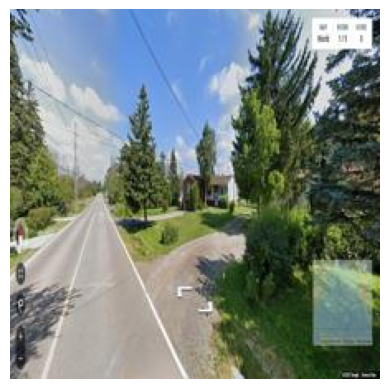

In [38]:
from IPython.display import Image as notebookImage

image = get_random_image()
print("Image from:", image["country"])
notebookImage(filename=image["image_path"])

predict(new_model, image["image_path"])

What a pleasant surprise! It guessed it correctly with high confidence!